# Plane stress and plane strain plasticity 

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/plasticity.ipynb)

This example demonstrates the use of non-linear material models, specifically plane stress and plane strain isotropic linear hardening plasticity.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import (
    IsotropicElasticityPlaneStress,
    IsotropicPlasticityPlaneStrain,
    IsotropicPlasticityPlaneStress,
)

# Set double precision
torch.set_default_dtype(torch.float64)

# Material model (plane stress)
material = IsotropicElasticityPlaneStress(E=1000.0, nu=0.3)

## Plane Stress Plasticity

We test a plane stress projected von Mises model with isotropic hardening for a simple plate with a hole. 



#### Material properties 
The elastic material is plane stress isotropic elasticity. The plastic hardening is modeled as a linear hardening function given by

$$
\sigma_f(q) = \sigma_y + k q
$$

with the yield stress $\sigma_y$, the equivalent plastic strain $q$ and the hardening modulus $k$.

#### Newton-Raphson return-mapping algorithm 

The planar stress plasticity problem is actually a bit more tricky than the 3D problem, because stress states have to be projected to the planar state. This implementation follows de Souza Neto et al., specifically the algorithms lined out in Box 9.3 to Box 9.6 [1].

In each step, we compute a trial stress 
$$ 
\sigma_{\text{trial}} = \sigma_n + C : \Delta\varepsilon
$$
and check if it exceeds the yield surface by evaluating the squared flow potential
$$ 
\psi = \frac{1}{2}\sigma_{\text{trial}}^\top P \sigma_{\text{trial}} - \frac{1}{3} \sqrt{\frac{2}{3}}\sigma_f(q)^2 
\quad \text{with} \quad P = \frac{1}{3}\begin{bmatrix} 2 & -1 & 0 \\ -1 & 2 & 0 \\ 0 & 0 & 6 \end{bmatrix}.
$$


1. If $\psi \leq 0$, the stress state is elastic. We update the variables as follows: 
   $$
   \sigma_{n+1} = \sigma_{\text{trial}} \\ q_{n+1} = q_{n}\\ d\sigma d\varepsilon_{n+1} = C.
   $$

2. If $\psi > 0$, the stress state is plastic. We need to calculate the equivalent plastic strain $\Delta \gamma$ that leads to $\psi=0$ to satisfy the yield condition. This is a nonlinear equation and we solve it with a Newton-Raphson algorithm. We start with $\Delta \gamma=0$ and compute in each iteration the residual
   $$
   \xi = \frac{(\sigma_{11}^{\text{trial}} + \sigma_{22}^{\text{trial}})^2 }{6 (1 + \frac{E  \Delta \gamma }{3(1 - \nu)})^2}
      + \frac{\frac{1}{2}(\sigma_{22}^{\text{trial}} - \sigma_{11}^{\text{trial}})^2 + 2 (\sigma_{12}^{\text{trial}})^2 }{(1 + 2  G  \Delta \gamma)^2}\\
   q = q_n + \sqrt{\frac{2}{3} \xi} \Delta \gamma\\
   \psi = \frac{1}{2} \xi - \frac{1}{3} \sigma_f(q)^2
   $$
   and its derivative
   $$
   H = \sigma_f'(q)\\
   \xi' = -\frac{(\sigma_{11}^{\text{trial}} + \sigma_{22}^{\text{trial}})^2 }{9 (1 + \frac{E  \Delta \gamma }{3(1 - \nu)})^3} \frac{E}{1 - \nu}
      - 2 G \frac{(\sigma_{22}^{\text{trial}} - \sigma_{11}^{\text{trial}})^2 + 4 (\sigma_{12}^{\text{trial}})^2 }{(1 + 2  G  \Delta \gamma)^3}\\
   H' = 2 \sigma_f(q) H \sqrt(\frac{2}{3}) (\sqrt{\xi} + \frac{\Delta \gamma \xi' }{2 * \sqrt{\xi}})
   \psi' = \frac{1}{2} \xi' - \frac{1}{3} H'
   $$
   to update $\Delta \gamma$ according to
   $$
   \Delta \gamma = \Delta \gamma - \frac{\psi}{\psi'}
   $$
   until $\psi$ is sufficiently small. Then, we update the variables as follows
   $$
   \sigma_{n+1} = I C \sigma_{\text{trial}} \\ q_{n+1} = q\\ d\sigma d\varepsilon_{n+1} = I - \alpha n \otimes n.
   $$
   with 
   $$
   I = [C+\Delta \gamma P ]^{-1}\\
   n = I P  \sigma_{n+1}\\
   \alpha = \frac{1}{ \sigma_{n+1}^\top P  \sigma_{n+1} + \frac{2\xi H}{3- 2 H \Delta \gamma}}.
   $$

[1] de Souza Neto, E. A., Peri, D., Owen, D. R. J. *Computational Methods for Plasticity*, Chapter 9: Plane Stress Plasticity, https://doi.org/10.1002/9780470694626.ch9, 2008.

In [2]:
# Material properties
E = 1000.0
nu = 0.3
sigma_y = 10.0
k = 10.0


# Hardening function
def sigma_f(q):
    return sigma_y + k * q


# Derivative of the hardening function
def sigma_f_prime(q):
    return k


# Elastic properties
material = IsotropicPlasticityPlaneStress(E, nu, sigma_f, sigma_f_prime)

#### Geometry 
The geometry is a plate with a hole, imported from the example files. It is fully clamped on the left hand side and subjected to a line fore on the right hand side, which is applied in 20 increments. One of the first elements to yield is element 405, which is highlighted black in the following plot.

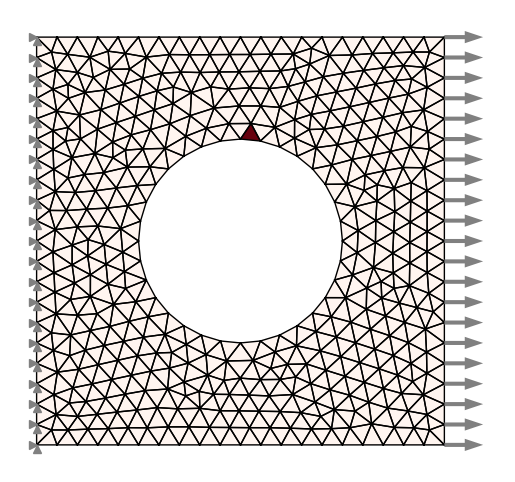

In [3]:
# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Applied load
load = 5.0


# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material)
plate.thickness[:] = t

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
weigths = 2.0 * torch.ones(right.sum())
weigths[0] = 1.0
weigths[1] = 1.0
plate.forces[right, 0] = load * L * t * weigths / weigths.sum()

# Indicator function to highlight the element for later comparison
indicator = torch.zeros(len(plate.elements))
indicator[405] = 1.0

plate.plot(element_property=indicator, cmap="Reds")

In [4]:
increments = np.linspace(0, 1.0, 21)
u, f, σ, ε, α = plate.solve(increments=increments, return_intermediate=True)

#### Postprocessing

To verify the implementation, we compare stress and strain to a solution obtained with ABAQUS and visualize the plastic equivalent strain on the plate.

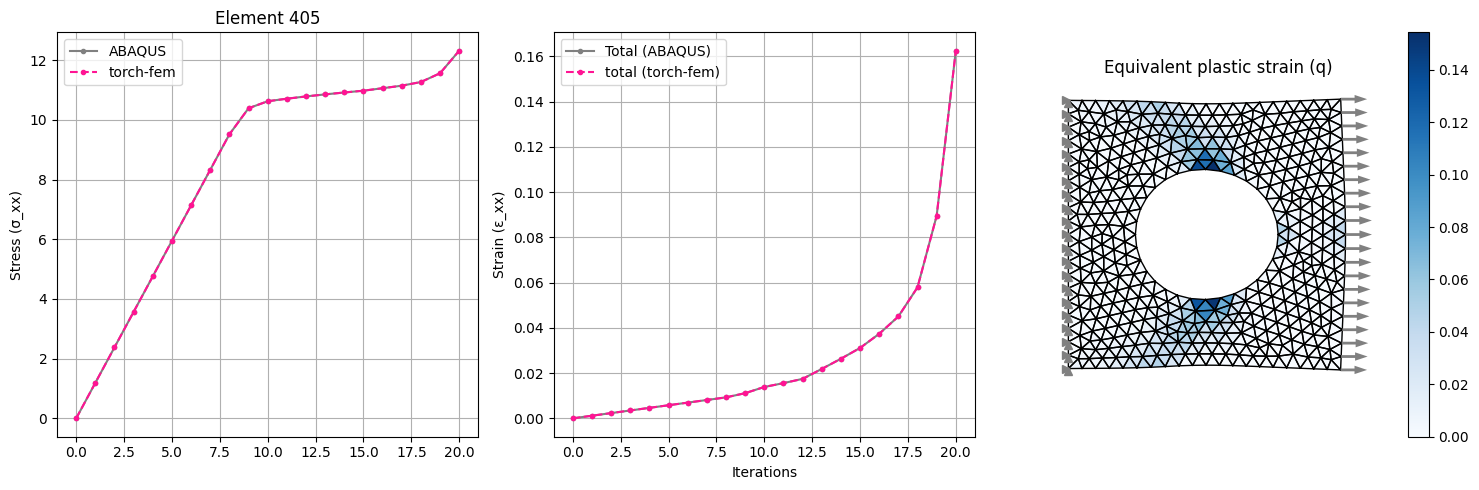

In [5]:
ref_data = np.array(
    [
        [0.00000000, 0.00000],
        [0.00115863, 1.18972],
        [0.00231726, 2.37944],
        [0.00347588, 3.56916],
        [0.00463451, 4.75888],
        [0.00579314, 5.94860],
        [0.00695177, 7.13832],
        [0.00811039, 8.32804],
        [0.00926902, 9.51776],
        [0.01112870, 10.3928],
        [0.01386970, 10.6270],
        [0.01556670, 10.7136],
        [0.01745850, 10.7888],
        [0.02183210, 10.8568],
        [0.02634620, 10.9203],
        [0.03111430, 10.9806],
        [0.03737260, 11.0636],
        [0.04502770, 11.1487],
        [0.05791700, 11.2713],
        [0.08955470, 11.5656],
        [0.16253600, 12.3205],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()

ax[1].plot(ref_data[:, 0], ".-", color="gray", label="Total (ABAQUS)")
ax[1].plot(ε[:, 405, 0], ".--", color="deeppink", label="total (torch-fem)")
ax[1].grid()
ax[1].set_ylabel("Strain (ε_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    element_property=α[-1, :, 0],
    cmap="Blues",
    colorbar=True,
    title="Equivalent plastic strain (q)",
    ax=ax[2],
)
plt.tight_layout()
plt.show()

## Plane Strain Plasticity

We implement a plane stress projected von Mises model with isotropic hardening for a simple plate with a hole. 



#### Material properties 
The elastic material is plane stress isotropic elasticity. The plastic hardening is modeled as a linear hardening function given by

$$
\sigma_f(q) = \sigma_y + k q
$$

with the yield stress $\sigma_y$, the equivalent plastic strain $q$ and the hardening modulus $k$.


##### Return mapping algorithm 
The return mapping algorithm works exactly as in 3D by expanding the stress state to 2D. Here, the out of plane stress is computed as 
$$
\sigma_{zz} = \nu (\sigma_{xx}+\sigma_{yy}) - E \varepsilon_z^p,
$$
where $\varepsilon_z^p$ is the out-of-plane plastic strain which is stored in an additional state variable.


In [6]:
# Material properties
E = 1000.0
nu = 0.3
sigma_y = 10.0
k = 10.0


# Hardening function
def sigma_f(q):
    return sigma_y + k * q


# Derivative of the hardening function
def sigma_f_prime(q):
    return k


# Elastic properties
material = IsotropicPlasticityPlaneStrain(E, nu, sigma_f, sigma_f_prime)

In [7]:
# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Applied load
load = 5.0


# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material)
plate.thickness[:] = t

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
weigths = 2.0 * torch.ones(right.sum())
weigths[0] = 1.0
weigths[1] = 1.0
plate.forces[right, 0] = load * L * t * weigths / weigths.sum()

In [8]:
increments = np.linspace(0, 1.0, 21)
u, f, σ, ε, α = plate.solve(increments=increments, return_intermediate=True)

#### Postprocessing

To verify the implementation, we compare stress and strain to a solution obtained with ABAQUS and visualize the plastic equivalent strain on the plate.

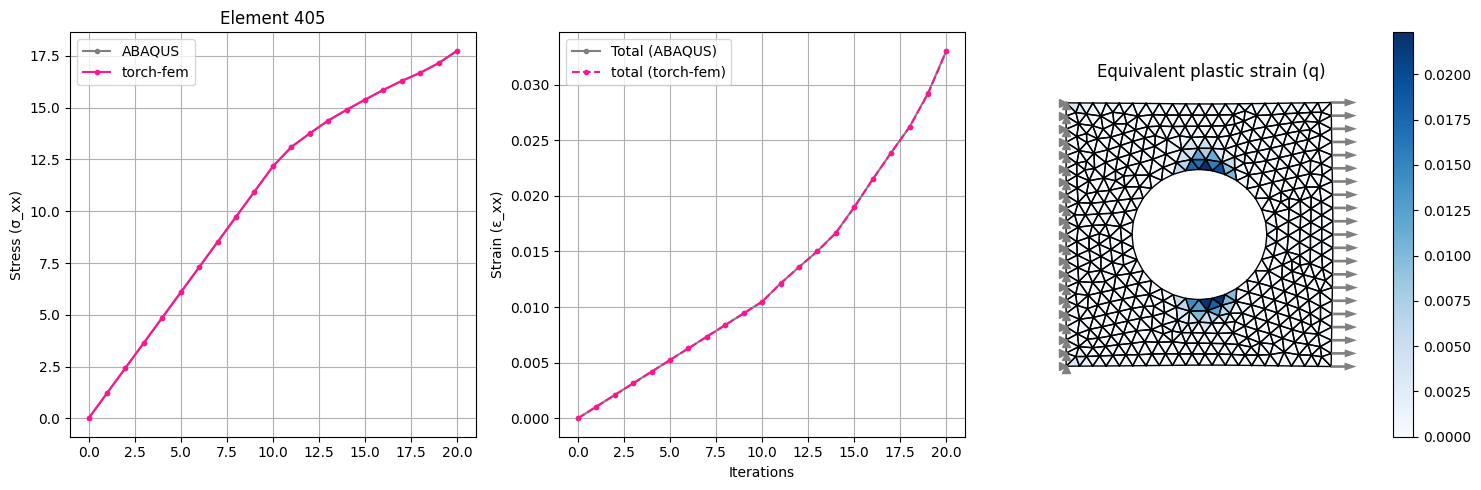

In [9]:
ref_data = np.array(
    [
        [0.00000000, 0.00000],
        [0.00104847, 1.21618],
        [0.00209693, 2.43235],
        [0.00314540, 3.64853],
        [0.00419386, 4.86471],
        [0.00524233, 6.08089],
        [0.00629079, 7.29706],
        [0.00733926, 8.51324],
        [0.00838772, 9.72942],
        [0.00943619, 10.9456],
        [0.01048470, 12.1618],
        [0.01212030, 13.0977],
        [0.01358690, 13.7502],
        [0.01501900, 14.3720],
        [0.01666450, 14.8937],
        [0.01898940, 15.3819],
        [0.02147310, 15.8497],
        [0.02386260, 16.2904],
        [0.02618770, 16.6802],
        [0.02921480, 17.1496],
        [0.03303750, 17.7495],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0], ".-", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()

ax[1].plot(ref_data[:, 0], ".-", color="gray", label="Total (ABAQUS)")
ax[1].plot(ε[:, 405, 0], ".--", color="deeppink", label="total (torch-fem)")
ax[1].grid()
ax[1].set_ylabel("Strain (ε_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    element_property=α[-1, :, 0],
    cmap="Blues",
    colorbar=True,
    title="Equivalent plastic strain (q)",
    ax=ax[2],
)
plt.tight_layout()
plt.show()